In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

As a toy example we will use the ```make_multilabel_classification``` 

In [2]:
from sklearn.datasets import make_multilabel_classification

n_classes=2
n_features=2
avg_n_labels_per_instance = 1 

X, Y = make_multilabel_classification(n_samples=200, 
                                      n_features=n_features, 
                                      n_classes=n_classes, 
                                      n_labels=avg_n_labels_per_instance, 
                                      length=50, 
                                      allow_unlabeled=False, 
                                      sparse=False, 
                                      return_indicator='dense', 
                                      return_distributions=False, 
                                      random_state=0)

In this toy example we will explain the decision of a OneVsRest-Adaboost classifier

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
bb = OneVsRestClassifier(AdaBoostClassifier(n_estimators=2000, random_state=0))
bb.fit(X_train, y_train)  
y_pred = bb.predict(X_test)
print(f'prediction performance of the black-box, F1-score: {round(f1_score(y_test, y_pred, average="macro"),3)}')

prediction performance of the black-box, F1-score: 0.789


Suppose we want to explain the black box decision of this instance:

In [4]:
i2e_id = 10
instance_to_be_explained = X[i2e_id].reshape(1, -1)
bb.predict(instance_to_be_explained)

array([[1, 1]])

Since this is a 2D example we can visualize the points and their classification according to the black box.

The one we want to explain is annotated using the black arrow

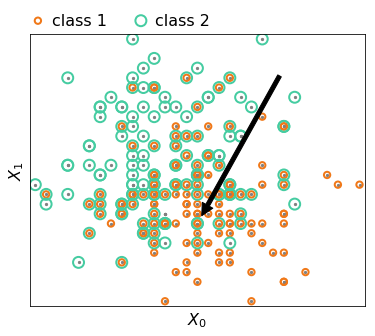

In [14]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

colors = ['#F07818', '#45CCA1']
sizes = [40, 120]

plt.figure(figsize=(6,5))
plt.scatter(X[:, 0], X[:, 1], s=5, c='gray')

labels = ['Class1','Class2']

Y_bb = bb.predict(X)

for i in range(0, n_classes):
    plt.scatter(X[np.where(Y_bb[:, i]), 0], X[np.where(Y_bb[:, i]), 1], s=sizes[i], edgecolors=colors[i],
                facecolors='none', linewidths=2, label='class %d' % (i+1))

plt.annotate("", xy=(X[i2e_id][0], X[i2e_id][1]), xytext=(35, 35), arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.xlabel(r'$X_0$', fontsize=16)
plt.ylabel(r'$X_1$', fontsize=16)
plt.legend(loc=(0,1), fontsize=16, ncol=3, labelspacing=0, handlelength=0.2, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('./synthetic_plot.png')

In [6]:
from marlena import marlena

Istantiate the MARLENA object

In [7]:
m1 = marlena.MARLENA(neigh_type='mixed',random_state=42)

To extract the explanation, MARLENA needs:
* the black box ```bb```
* the instance whose black box decision we want to explain ```i2e = instance_to_be_explained```
* the name of the classes ```labels_name = ['class1', 'class2']```
* the names of categorical and numerical variables, in our case they are all numerical: ```numerical_vars = ['feature_one','feature_two']```, ```categorical_vars = []```
* a set of instances representative of the dataset that was used to train the black box, e.g. the training set ```X2E = X_train```


In [8]:
labels_name = ['class1', 'class2']
numerical_vars = ['feature_one','feature_two']
categorical_vars = []
i2e = pd.Series(instance_to_be_explained[0],index=numerical_vars)
X2E = pd.DataFrame(X_train,columns=numerical_vars)

#### MARLENA hyperparameters:
* **k**: number of real neighbors to use to generate the synthetic ones 
* **alpha**: fraction of neighbors to be sampled from the feature space
* **k_synth**: number of synthetic neighbors

In [9]:
k = 10
k_synt = 500
alpha = 0.7

### MARLENA "extract_explanation" method:

In [10]:
rule, instance_imporant_feat, fidelity, hit, DT = m1.extract_explanation(i2e,
                                                                         X2E,
                                                                         bb,
                                                                         numerical_vars,
                                                                         categorical_vars,
                                                                         labels_name,
                                                                         k=k,
                                                                         size=k_synt,
                                                                         alpha=alpha)

/home/user/venvs/MARLENA_env/lib/python3.6/site-packages/marlena/distances.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.var(x - y) / (np.var(x) + np.var(y))


### Marlena output:

MARLENA provides rule-based explanations. The explanation is the decision tree path from root to leaf that matches the features of the instance whose black-box classification we want to explain. 

In [11]:
print(rule)

{feature_two <= 23.03,
 feature_one > 24.0,
 feature_two > 16.53,
 feature_two > 17.49,
 feature_one > 24.46,
 feature_one <= 35.46,
 feature_two <= 21.51,
 feature_two <= 20.43,
 feature_two <= 20.39,
 feature_two > 18.7,
 feature_two > 18.75,
 feature_two <= 19.48,
 feature_two <= 19.44,
 feature_two <= 19.08,
 feature_one <= 31.32,
 feature_two > 18.88,
 feature_one <= 28.26,
 feature_two <= 19.03} -> ['class1' 'class2']


Together with the rule-based explanation, MARLENA also provides some metrics to evaluate the quality of the explanation: fidelity adn hit.


The **fidelity** compares the decisions of the DT to those of the black-box on the synthetic neighborhood. It is measured using the *F1-score*.
$$fidelity(Y,\hat{Y})\in\left[0,1\right]$$


The **hit** compares the predictions of the DT and the black-box on the instance x under analysis. It is mesured usinf the *simple match similarity* 
$$hit(y,\hat{y})) = 1 − hamming(y, ŷ) \in \left[0,1\right]$$

In [12]:
print(fidelity)

1.0


In [13]:
print(hit)

1.0
